In [1]:
%cd ../

/mnt2/kireev/pycharm-deploy/pytorch-lifestream/experiments/scenario_alpha_battle


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
import matplotlib.pyplot as plt

In [4]:
from glob import glob
import json

In [16]:
def read_emb_val_results(path, pattern, with_epochs=True):
    df_results = []
    for p in glob(path):
        with open(p, 'r') as f:
            df_results.append(json.load(f))
    df = pd.json_normalize([t for l in df_results for t in l])
    if with_epochs:
        df = df.assign(epoch_num=lambda x: pd.to_numeric(x['feature_name'].str.extract(f'{pattern}__(\d+)')[0]))
    else:
        df = df.assign(epoch_num=-1)
    df = df.assign(method=pattern)
    return pd.concat([
        df[['method', 'epoch_num', 'scores_valid.auroc', 'fold_id', 'feature_name']]
        .rename(columns={'scores_valid.auroc': 'auroc'}).assign(part='valid'),
        df[['method', 'epoch_num', 'scores_test.auroc', 'fold_id', 'feature_name']]
        .rename(columns={'scores_test.auroc': 'auroc'}).assign(part='test'),
    ], axis=0).reset_index(drop=True)

In [7]:
df_baseline = read_emb_val_results('conf/embeddings_validation.work/m_lgbm__f_baseline__i_?/results.json', 
                                   'baseline', with_epochs=False).groupby('part')['auroc']

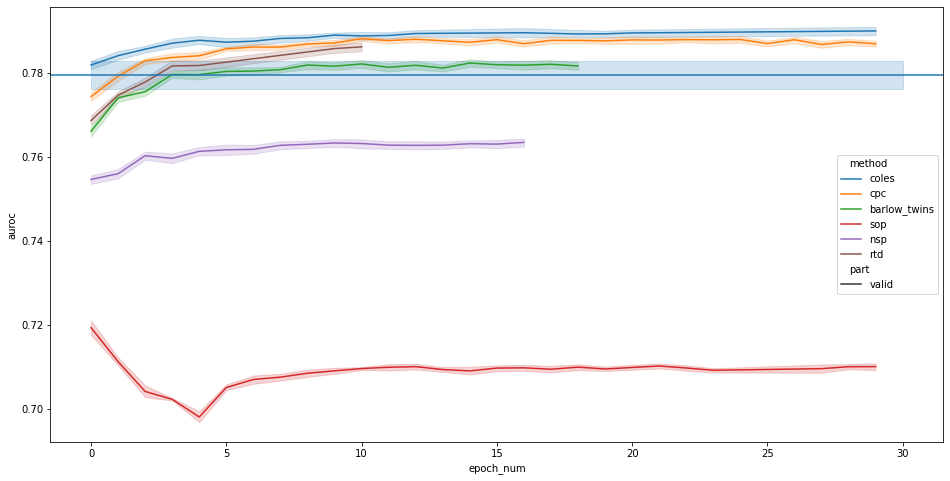

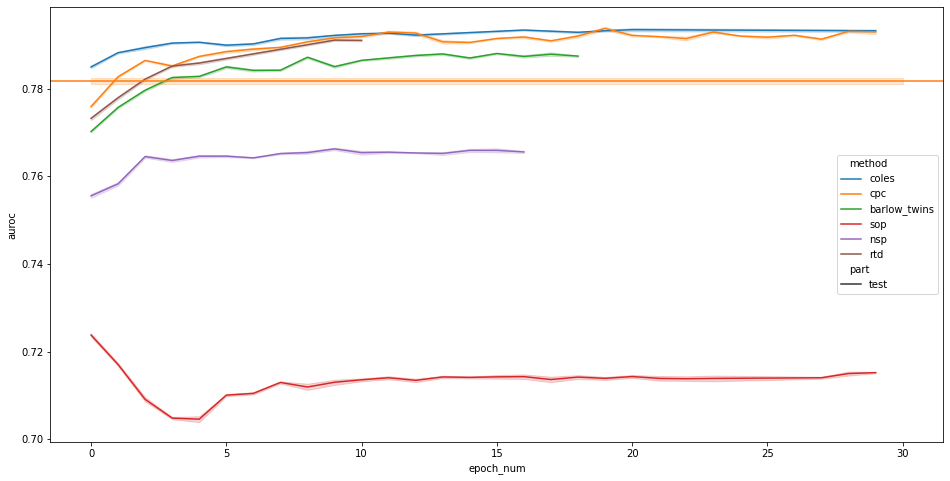

In [17]:
for part in ('valid', 'test'):
    _, ax = plt.subplots(1, 1, figsize=(16, 8))
    sns.lineplot(
        data=pd.concat([
            read_emb_val_results(
                'conf/embeddings_validation_remote.work/m_lgbm__f_mles__???__i_?/results.json', 'coles'),
            read_emb_val_results(
                'conf/embeddings_validation_remote.work/m_lgbm__f_cpc__???__i_?/results.json', 'cpc'),
            read_emb_val_results(
                'conf/embeddings_validation_remote.work/m_lgbm__f_barlow_twins__???__i_?/results.json', 
                                 'barlow_twins'),
            read_emb_val_results(
                'conf/embeddings_validation.work/m_lgbm__f_sop__???__i_?/results.json', 'sop'),
            read_emb_val_results(
                'conf/embeddings_validation_remote.work/m_lgbm__f_nsp__???__i_?/results.json', 'nsp'),
            read_emb_val_results(
                'conf/embeddings_validation_remote.work/m_lgbm__f_rtd__???__i_?/results.json', 'rtd'),
        ], axis=0).reset_index(drop=True)[lambda x: x['part'].isin([part])],
        x='epoch_num',
        y='auroc',
        hue='method', style='part',
        ax=ax,
        ci=65,
    )

    if part == 'valid':
        plt.axhline(df_baseline.mean()['valid'], 
                    color=plt.get_cmap('tab10')(0), label='valid')
        plt.fill_between([0, 30], 
                         df_baseline.mean()['valid'] - df_baseline.std()['valid'],
                         df_baseline.mean()['valid'] + df_baseline.std()['valid'], 
                         color=plt.get_cmap('tab10')(0), alpha=0.2)
    if part == 'test':
        plt.axhline(df_baseline.mean()['test'],
                    color=plt.get_cmap('tab10')(1), label='test')
        plt.fill_between([0, 30], 
                         df_baseline.mean()['test'] - df_baseline.std()['test'],
                         df_baseline.mean()['test'] + df_baseline.std()['test'], 
                         color=plt.get_cmap('tab10')(1), alpha=0.2)

    # plt.xscale('log')
    plt.show()